   
# Resume Parse
## 1. Import packages
  

In [1]:
import re
import string
import nltk
import time
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from matplotlib import pyplot
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.gofplots import qqplot


# supress sklearn warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

%matplotlib inline

## 2. Wrangle data
1. Read data
2. Clean data
    1. Remove stops
    2. Remove punctuation
3. Stem data
4. Add features
    1. Line length: total non-whitespace characters
    2. Verb percentage: portion of verbs per line
    3. Stop word percentage: portion of stop words per line
    4. Punctuation percentage: portion of punction per line

In [2]:
stopwords = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()
wn = nltk.WordNetLemmatizer()
verb_tags = ['VB','VBG','VBD', 'VBN','VBN-HL','VERB']
data = pd.read_csv('./dev/raw_in.csv', sep=',')

data


,line,label
0,Bernard Foster,Name
1,"Smyrna, GA 30082 ...",Contact
2,Bernard Foster is a Solutions Architect with a...,Summary
3,Professional Experience,Heading
4,"Research 1, Inc S...",Unknown
...,...,...
1001,November 2003 - March 2007,Date
1002,Earned $2344.00 in cash awards and 16 vacation...,Bullet
1003,EDUCATION,Heading
1004,"Bachelor of Science, Business Information Syst...",Degree


## Clean and adjust data

In [3]:
def clean_text(text):
    text = ''.join([word for word in text if word not in string.punctuation])
    tokens = re.split('\W+',text)
    text = [word for word in tokens if word not in stopwords]
    return text

def get_stems(tokenized_text):
    text = [ps.stem(word) for word in tokenized_text]
    return text

def count_verbs(pos_tags: list) -> int:
    count = sum([1 for pair in pos_tags if pair[1] in verb_tags])
    return round(count/(len(pos_tags)),3)*100

def count_stopwords(line: str) -> int:
    count = sum([1 for word in nltk.word_tokenize(line) if word in nltk.corpus.stopwords.words('english')])
    return round(count/(len(line) - line.count(' ')),3)*100

def count_punct(line: str) -> int:
    count = sum([1 for char in line if char in string.punctuation])
    return round(count/(len(line) - line.count(' ')), 3)*100

data['line_nostop'] = data['line'].apply(lambda x: clean_text(x.lower()))

data['line_stemmed'] = data['line_nostop'].apply(lambda x: get_stems(x))

data['line_length'] = data['line'].apply(lambda x: len(x) - x.count(' '))

data['tagged_line'] = data['line'].apply(lambda x: nltk.pos_tag(nltk.word_tokenize(x)))

data['verb_percentage'] = data['tagged_line'].apply(lambda x: count_verbs(x))

data['stopword_percentage'] = data['line'].apply(lambda x: count_stopwords(x))

data['punctuation_percentage'] = data['line'].apply(lambda x: count_punct(x))

data['is_bullet'] = np.where(data['label'] == 'Bullet', 1, 0)


data

,line,label,line_nostop,line_stemmed,line_length,tagged_line,verb_percentage,stopword_percentage,punctuation_percentage,is_bullet
0,Bernard Foster,Name,"[bernard, foster]","[bernard, foster]",13,"[(Bernard, NNP), (Foster, NNP)]",0.0,0.0,0.0,0
1,"Smyrna, GA 30082 ...",Contact,"[smyrna, ga, 30082, cell, 404, 6616742, bernar...","[smyrna, ga, 30082, cell, 404, 6616742, bernar...",57,"[(Smyrna, NNP), (,, ,), (GA, NNP), (30082, CD)...",0.0,0.0,10.5,0
2,Bernard Foster is a Solutions Architect with a...,Summary,"[bernard, foster, solutions, architect, vast, ...","[bernard, foster, solut, architect, vast, amou...",698,"[(Bernard, NNP), (Foster, NNP), (is, VBZ), (a,...",4.1,4.9,2.7,0
3,Professional Experience,Heading,"[professional, experience]","[profession, experi]",22,"[(Professional, JJ), (Experience, NN)]",0.0,0.0,0.0,0
4,"Research 1, Inc S...",Unknown,"[research, 1, inc, salesforce, administratorco...","[research, 1, inc, salesforc, administratorcon...",67,"[(Research, NN), (1, CD), (,, ,), (Inc, NNP), ...",10.0,1.5,3.0,0
...,...,...,...,...,...,...,...,...,...,...
1001,November 2003 - March 2007,Date,"[november, 2003, march, 2007]","[novemb, 2003, march, 2007]",22,"[(November, NNP), (2003, CD), (-, :), (March, ...",0.0,0.0,4.5,0
1002,Earned $2344.00 in cash awards and 16 vacation...,Bullet,"[earned, 234400, cash, awards, 16, vacation, h...","[earn, 234400, cash, award, 16, vacat, hour, j...",62,"[(Earned, VBD), ($, $), (2344.00, CD), (in, IN...",7.1,4.8,4.8,1
1003,EDUCATION,Heading,[education],[educ],9,"[(EDUCATION, NN)]",0.0,0.0,0.0,0
1004,"Bachelor of Science, Business Information Syst...",Degree,"[bachelor, science, business, information, sys...","[bachelor, scienc, busi, inform, system, belle...",73,"[(Bachelor, NN), (of, IN), (Science, NNP), (,,...",0.0,1.4,5.5,0


In [4]:
# Data types
data.dtypes

line                       object
label                      object
line_nostop                object
line_stemmed               object
line_length                 int64
tagged_line                object
verb_percentage           float64
stopword_percentage       float64
punctuation_percentage    float64
is_bullet                   int64
dtype: object

In [5]:
# See distrobution of target variable ('Bullet')
data['is_bullet'].value_counts()

0    627
1    379
Name: is_bullet, dtype: int64

In [6]:
# Print all "is_bullet" with line_length < 20


short_bullets = data[(data['is_bullet'] == 1) & (data['line_length'] < 20)]
short_bullets

,line,label,line_nostop,line_stemmed,line_length,tagged_line,verb_percentage,stopword_percentage,punctuation_percentage,is_bullet
256,temporary,Bullet,[temporary],[temporari],9,"[(temporary, JJ)]",0.0,0.0,0.0,1
266,previous year,Bullet,"[previous, year]","[previou, year]",12,"[(previous, JJ), (year, NN)]",0.0,0.0,0.0,1
282,assistant,Bullet,[assistant],[assist],9,"[(assistant, NN)]",0.0,0.0,0.0,1
334,Units.,Bullet,[units],[unit],6,"[(Units, NNS), (., .)]",0.0,0.0,16.7,1
392,Data Studio and Looker,Bullet,"[data, studio, looker]","[data, studio, looker]",19,"[(Data, NNP), (Studio, NNP), (and, CC), (Looke...",0.0,5.3,0.0,1
399,retrieval,Bullet,[retrieval],[retriev],9,"[(retrieval, NN)]",0.0,0.0,0.0,1
402,platform.,Bullet,[platform],[platform],9,"[(platform, NN), (., .)]",0.0,0.0,11.1,1
419,● Onboarding task,Bullet,"[, onboarding, task]","[, onboard, task]",15,"[(●, NN), (Onboarding, NNP), (task, NN)]",0.0,0.0,0.0,1
427,the world.,Bullet,[world],[world],9,"[(the, DT), (world, NN), (., .)]",0.0,11.1,11.1,1
452,equipment.,Bullet,[equipment],[equip],10,"[(equipment, NN), (., .)]",0.0,0.0,10.0,1


In [7]:
# Get numeric features only by dropping categorical features.


cat_feat = ['line', 'label','line_nostop','line_stemmed','tagged_line']
numeric_only = data.drop(cat_feat, axis=1)
numeric_only

,line_length,verb_percentage,stopword_percentage,punctuation_percentage,is_bullet
0,13,0.0,0.0,0.0,0
1,57,0.0,0.0,10.5,0
2,698,4.1,4.9,2.7,0
3,22,0.0,0.0,0.0,0
4,67,10.0,1.5,3.0,0
...,...,...,...,...,...
1001,22,0.0,0.0,4.5,0
1002,62,7.1,4.8,4.8,1
1003,9,0.0,0.0,0.0,0
1004,73,0.0,1.4,5.5,0


In [8]:
# Look at general distrobution of these features
numeric_only.describe()

,line_length,verb_percentage,stopword_percentage,punctuation_percentage,is_bullet
count,1006.000000,1006.000000,1006.000000,1006.000000,1006.00000
mean,67.814115,4.668787,2.017097,3.751690,0.37674
std,107.621847,9.020396,2.548894,8.561202,0.48481
min,3.000000,0.000000,0.000000,0.000000,0.00000
25%,19.000000,0.000000,0.000000,0.000000,0.00000
50%,40.000000,0.000000,0.000000,2.100000,0.00000
75%,80.000000,7.400000,3.800000,4.600000,1.00000
max,1682.000000,100.000000,20.000000,100.000000,1.00000


In [9]:
# Look at the correlation matrix. The best features have a strong correlation
# with the target variable only. If there is a strong correlation between other
# features, it can confuse the model. This must still be tested, but looking
# at a simple correlation matrix is helpful.

numeric_only.corr()

,line_length,verb_percentage,stopword_percentage,punctuation_percentage,is_bullet
line_length,1.000000,0.176698,0.282802,0.017763,0.354091
verb_percentage,0.176698,1.000000,0.319386,-0.119124,0.320322
stopword_percentage,0.282802,0.319386,1.000000,-0.148704,0.568658
punctuation_percentage,0.017763,-0.119124,-0.148704,1.000000,-0.105720
is_bullet,0.354091,0.320322,0.568658,-0.105720,1.000000


In [10]:
# Group by the two levels of the 'is_bullet' column
# Look at the distribution of each feature for bullets and non-bullets
# Run a t-test on the two distributions to see if the difference
#    is statistacally significant

def describe_cont_feature(feature):
    print('\n*** Results for {}'.format(feature))
    print(data.groupby('is_bullet')[feature].describe())
    print(ttest(feature))
    
def ttest(feature):
    bullet = data[data['is_bullet']==1][feature]
    not_bullet = data[data['is_bullet']==0][feature]
    tstat, pval = stats.ttest_ind(bullet, not_bullet, equal_var=False)
    print('t-statistic: {:.1f}, p-value: {:.3}'.format(tstat,pval))

In [11]:
# Look at the distribution of each feature at each level of the target variable
features = list(numeric_only.columns.values)

for feature in features:
    describe_cont_feature(feature)


*** Results for line_length
           count        mean         std  min   25%   50%    75%     max
is_bullet                                                               
0          627.0   38.200957   52.379371  3.0  14.0  24.0   43.0   698.0
1          379.0  116.804749  149.632792  6.0  55.0  82.0  109.0  1682.0
t-statistic: 9.9, p-value: 7.38e-21
None

*** Results for verb_percentage
           count      mean       std  min  25%  50%   75%    max
is_bullet                                                       
0          627.0  2.423445  9.065079  0.0  0.0  0.0   0.0  100.0
1          379.0  8.383377  7.618872  0.0  0.0  7.7  13.0   50.0
t-statistic: 11.2, p-value: 2.89e-27
None

*** Results for stopword_percentage
           count      mean       std  min  25%  50%  75%   max
is_bullet                                                     
0          627.0  0.890750  2.100276  0.0  0.0  0.0  0.0  20.0
1          379.0  3.880475  2.093424  0.0  2.7  3.9  5.1  12.2
t-statistic: 2

In [12]:
# Detect outliers
def detect_outlier(feature):
    outliers = []
    data = numeric_only[feature]
    mean = np.mean(data)
    std = np.std(data)
    
    for y in data:
        z_score = (y - mean)/std
        if np.abs(z_score) > 3:
            outliers.append(y)
    print('\nOutlier caps and floors for {}:'.format(feature))
    print('   --95p: {:.1f} / {} values exceed that.'.format(data.quantile(.95),
                                                            len([i for i in data
                                                                if i > data.quantile(.95)])))
    print('   --99p: {:.1f} / {} values exceed that.'.format(data.quantile(.99),
                                                     len([i for i in data
                                                            if i > data.quantile(.99)])))
    print('   --3sd: {:.1f} / {} values exceed that.'.format(mean + 3*(std), len(outliers)))

In [13]:
# Find upperbound for features
for feat in numeric_only.columns:
    detect_outlier(feat)


Outlier caps and floors for line_length:
   --95p: 215.0 / 51 values exceed that.
   --99p: 497.2 / 11 values exceed that.
   --3sd: 390.5 / 20 values exceed that.

Outlier caps and floors for verb_percentage:
   --95p: 20.0 / 41 values exceed that.
   --99p: 33.3 / 10 values exceed that.
   --3sd: 31.7 / 20 values exceed that.

Outlier caps and floors for stopword_percentage:
   --95p: 6.5 / 51 values exceed that.
   --99p: 10.0 / 7 values exceed that.
   --3sd: 9.7 / 13 values exceed that.

Outlier caps and floors for punctuation_percentage:
   --95p: 13.0 / 50 values exceed that.
   --99p: 23.4 / 11 values exceed that.
   --3sd: 29.4 / 7 values exceed that.

Outlier caps and floors for is_bullet:
   --95p: 1.0 / 0 values exceed that.
   --99p: 1.0 / 0 values exceed that.
   --3sd: 1.8 / 0 values exceed that.


### Cap features
Remove all records that are more than 3 $\sigma$ from $\mu$.


In [14]:
numeric_only['line_length'].clip(upper=390,inplace=True)
numeric_only.describe()

,line_length,verb_percentage,stopword_percentage,punctuation_percentage,is_bullet
count,1006.000000,1006.000000,1006.000000,1006.000000,1006.00000
mean,62.879722,4.668787,2.017097,3.751690,0.37674
std,72.374279,9.020396,2.548894,8.561202,0.48481
min,3.000000,0.000000,0.000000,0.000000,0.00000
25%,19.000000,0.000000,0.000000,0.000000,0.00000
50%,40.000000,0.000000,0.000000,2.100000,0.00000
75%,80.000000,7.400000,3.800000,4.600000,1.00000
max,390.000000,100.000000,20.000000,100.000000,1.00000


## 3. Test Features

### Testing Line Length

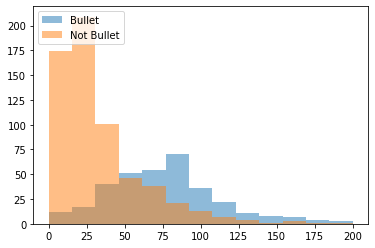

In [15]:
bins = np.linspace(0, 200, 14)

pyplot.hist(numeric_only[numeric_only['is_bullet']==1]['line_length'], bins, alpha=0.5, label='Bullet')
pyplot.hist(numeric_only[numeric_only['is_bullet']==0]['line_length'], bins, alpha=0.5, label='Not Bullet')
pyplot.legend(loc='upper left')
pyplot.show()

In [16]:
# calculate skew

### Testing verb percentage 

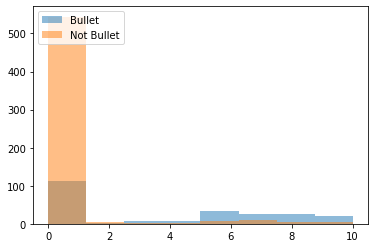

In [17]:
bins = np.linspace(0, 10, 9)

pyplot.hist(numeric_only[numeric_only['is_bullet']==1]['verb_percentage'], bins, alpha=0.5, label='Bullet')
pyplot.hist(numeric_only[numeric_only['is_bullet']==0]['verb_percentage'], bins, alpha=0.5, label='Not Bullet')
pyplot.legend(loc='upper left')
pyplot.show()

### Testing stop word percentage 

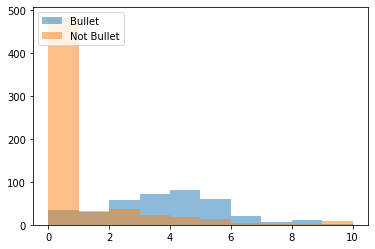

In [18]:
bins = np.linspace(0, 10, 11)

pyplot.hist(numeric_only[numeric_only['is_bullet']==1]['stopword_percentage'], bins, alpha=0.5, label='Bullet')
pyplot.hist(numeric_only[numeric_only['is_bullet']==0]['stopword_percentage'], bins, alpha=0.5, label='Not Bullet')
pyplot.legend(loc='upper left')
pyplot.show()

### Testing punctuation percentage 

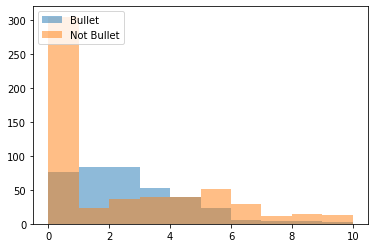

In [19]:
bins = np.linspace(0, 10, 11)

pyplot.hist(numeric_only[numeric_only['is_bullet']==1]['punctuation_percentage'], bins, alpha=0.5, label='Bullet')
pyplot.hist(numeric_only[numeric_only['is_bullet']==0]['punctuation_percentage'], bins, alpha=0.5, label='Not Bullet')
pyplot.legend(loc='upper left')
pyplot.show()

## Transforming Skewed Data

####  Process
1. Determine what range of exponents to test
2. Apply each transformation to each value of your chosen feature
3. Use some criteria to determine which of the transformations yeild the best distributions

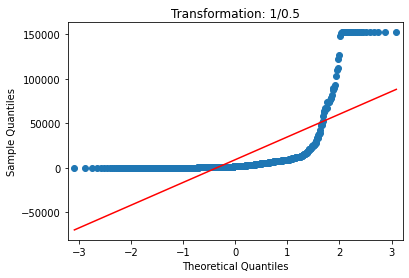

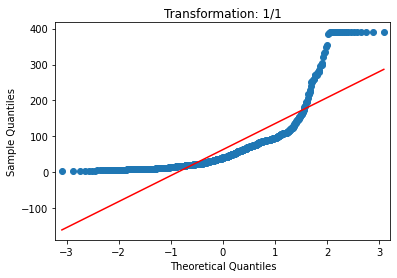

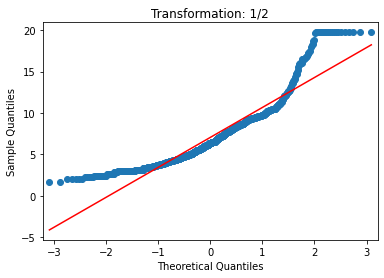

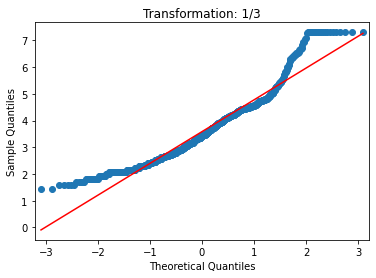

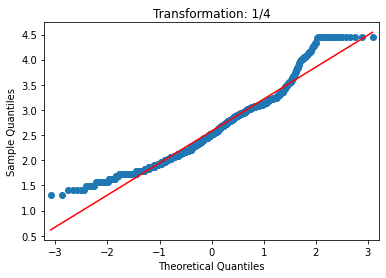

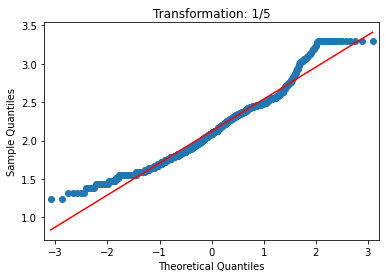

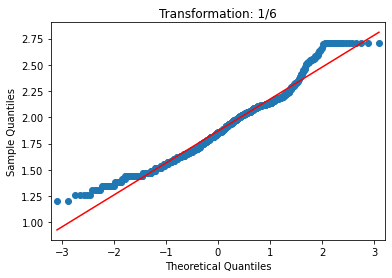

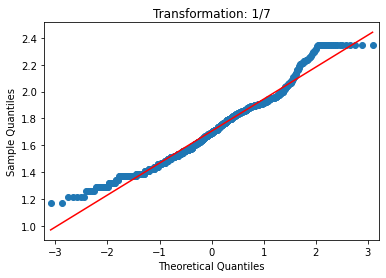

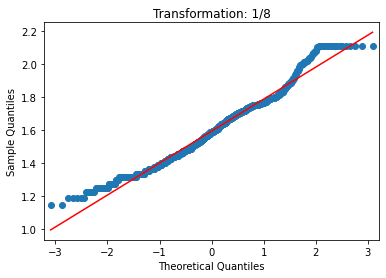

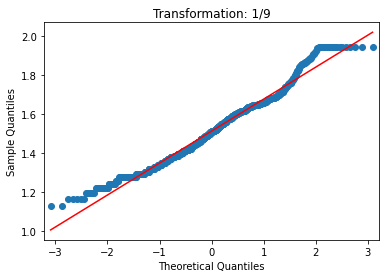

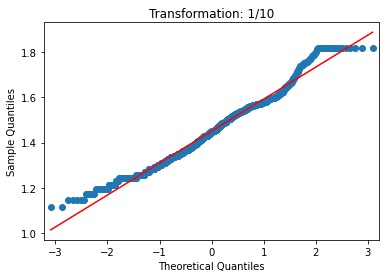

In [34]:
# Generate QQ plots
for i in [0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    data_t = numeric_only['line_length']**(1/i)
    qqplot(data_t, line='s')
    pyplot.title('Transformation: 1/{}'.format(str(i)))
    

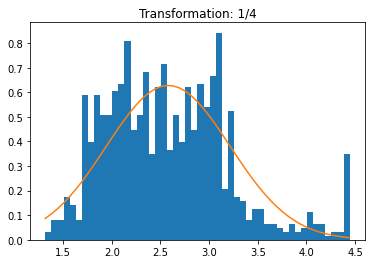

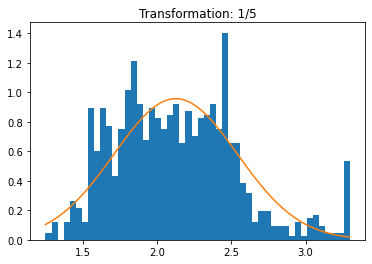

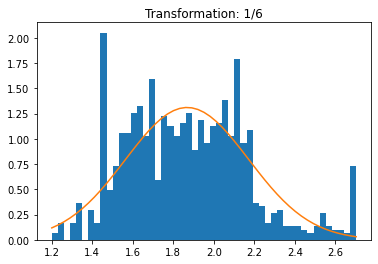

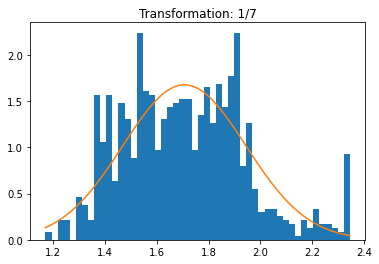

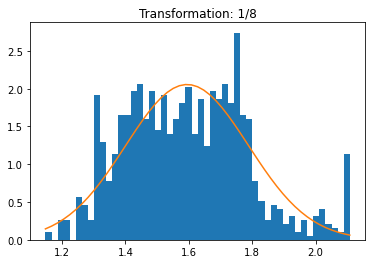

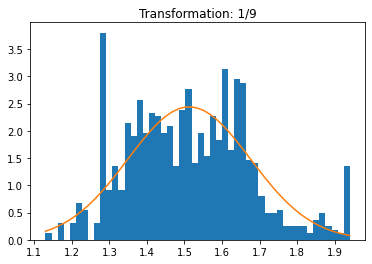

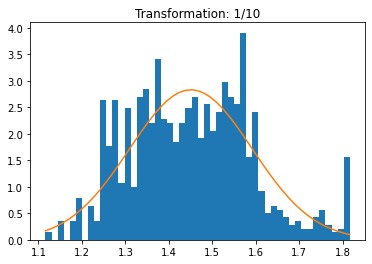

In [36]:
for i in range(4,11):
    data_t = numeric_only['line_length']**(1/i)
    n, bins, pathches = pyplot.hist(data_t, 50, density=True)
    mu = np.mean(data_t)
    sigma = np.std(data_t)
    pyplot.plot(bins, stats.norm.pdf(bins, mu, sigma))
    pyplot.title('Transformation: 1/{}'.format(str(i)))
    pyplot.show()

In [22]:
numeric_only['line_length_trans'] = numeric_only['line_length'].apply(lambda x : x**(1/10))

numeric_only['stopword_percentage_trans'] = numeric_only['stopword_percentage'].apply(lambda x : x**(1/2))

numeric_only['punctuation_percentage_trans'] = numeric_only['punctuation_percentage'].apply(lambda x : x**(1/2))


numeric_only.head()

,line_length,verb_percentage,stopword_percentage,punctuation_percentage,is_bullet,line_length_trans,stopword_percentage_trans,punctuation_percentage_trans
0,13,0.0,0.0,0.0,0,1.292392,0.000000,0.000000
1,57,0.0,0.0,10.5,0,1.498261,0.000000,3.240370
2,390,4.1,4.9,2.7,0,1.815961,2.213594,1.643168
3,22,0.0,0.0,0.0,0,1.362204,0.000000,0.000000
4,67,10.0,1.5,3.0,0,1.522676,1.224745,1.732051


## 4. Split into training, validation, and test sets

In [23]:
features = numeric_only.drop('is_bullet', axis=1)
labels = numeric_only['is_bullet']


X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

X_train.head()


,line_length,verb_percentage,stopword_percentage,punctuation_percentage,line_length_trans,stopword_percentage_trans,punctuation_percentage_trans
650,9,0.0,0.0,0.0,1.245731,0.000000,0.000000
448,71,6.2,5.6,1.4,1.531531,2.366432,1.183216
533,5,0.0,20.0,0.0,1.174619,4.472136,0.000000
622,36,0.0,0.0,0.0,1.430969,0.000000,0.000000
752,15,0.0,0.0,6.7,1.311019,0.000000,2.588436


In [24]:
print('Total records: {}\nTraining set:\t{}\nValidation set:\t{}\nTest set:\t{}'.format(len(labels), len(y_train), len(y_val), len(y_test)))

Total records: 1006
Training set:	603
Validation set:	202
Test set:	201


### Write out all data 

In [26]:
X_train.to_csv('output/train_features.csv', index=False)
X_val.to_csv('output/val_features.csv', index=False) 
X_test.to_csv('output/test_features.csv', index=False)

y_train.to_csv('output/train_labels.csv', index=False)
y_val.to_csv('output/val_labels.csv', index=False) 
y_test.to_csv('output/test_labels.csv', index=False)

In [30]:
# read in the data
bullet_train = pd.read_csv('output/train_features.csv')
bullet_val = pd.read_csv('output/val_features.csv')
bullet_test = pd.read_csv('output/test_features.csv')

bullet_test.head()

,line_length,verb_percentage,stopword_percentage,punctuation_percentage,line_length_trans,stopword_percentage_trans,punctuation_percentage_trans
0,29,0.0,3.4,0.0,1.400360,1.843909,0.000000
1,19,20.0,5.3,0.0,1.342380,2.302173,0.000000
2,33,0.0,0.0,0.0,1.418572,0.000000,0.000000
3,51,20.0,5.9,2.0,1.481689,2.428992,1.414214
4,10,0.0,0.0,0.0,1.258925,0.000000,0.000000


In [31]:
scaler = StandardScaler()
scaler.fit(bullet_train)

StandardScaler()

In [33]:
features = bullet_train.columns

bullet_train[features] = scaler.transform(bullet_train[features])
bullet_val[features] = scaler.transform(bullet_val[features])
bullet_test[features] = scaler.transform(bullet_test[features])

bullet_train.head()

,line_length,verb_percentage,stopword_percentage,punctuation_percentage,line_length_trans,stopword_percentage_trans,punctuation_percentage_trans
0,-0.755070,-0.530730,-0.782720,-0.440978,-1.475953,-0.927611,-0.989339
1,0.095895,0.169036,1.352764,-0.285326,0.553027,1.325359,-0.153603
2,-0.809971,-0.530730,6.844007,-0.440978,-1.980797,3.330102,-0.989339
3,-0.384489,-0.530730,-0.782720,-0.440978,-0.160893,-0.927611,-0.989339
4,-0.672719,-0.530730,-0.782720,0.303929,-1.012450,-0.927611,0.838941


## 5. Vectorize text

In [ ]:
# tfidf_vect = TfidfVectorizer(analyzer=clean_text)
# tfidf_vect_fit = tfidf_vect.fit(X_train['line'])

# tfidf_train = tfidf_vect_fit.transform(X_train['line'])
# tfidf_test = tfidf_vect_fit.transform(X_test['line'])

# X_train_vect = pd.concat([X_train[['line_length','verb_percentage','stopword_percentage','punctuation_percentage']].reset_index(drop=True),
#                          pd.DataFrame(tfidf_train.toarray())], axis=1)
# X_test_vect = pd.concat([X_test[['line_length','verb_percentage','stopword_percentage','punctuation_percentage']].reset_index(drop=True),
#                          pd.DataFrame(tfidf_test.toarray())], axis=1)

# X_train_vect.head()